# Training Neural Networks with Keras

Welcome to the first practical session of the course! In this session, we will learn how to train neural networks with Keras. We will start with a simple example of a feedforward neural network for classification and then we will study the impact of the initialization of the weights on the convergence of the training algorithm.

Keras is a high-level neural network API, built on top of TensorFlow 2.0. It provides a user-friendly interface to build, train and deploy deep learning models. Keras is designed to be modular, fast and easy to use.

Throughout this course, we will focus on using Keras and TensorFlow for building and training neural networks. However, there are other popular deep learning frameworks such as PyTorch, MXNet, CNTK, etc. that you can also use to build and train neural networks.

In order to use our code on Google Colab, we will need to ensure that any required packages are installed. We will use the following packages in this session:

- `tensorflow`: an open-source library for numerical computation and large-scale machine learning.
- `matplotlib`: a plotting library for the Python programming language and its numerical mathematics extension NumPy.
- `numpy`: a library for scientific computing in Python.
- `scikit-learn`: a machine learning library for the Python programming language.
- `pandas`: a library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

The following cell will check if the packages are installed, and if not, it will install them. Students familiar with how pip works might note that it already checks this before installing! The reason for this code (which will also appear in subsequent notebooks) is to speed up execution if you re-run the entire notebook - it will skip the installation step if the packages are already installed.

With the packages installed, we can now get started on the practical session!

Today, we will be working with the famous MNIST dataset. MNIST (Modified National Institute of Standards and Technology) is a database of low resolution images of handwritten digits. The history here is interesting - the dataset was originally created in the 1980s, when researchers from the aforementioned institute collected samples from American Census Bureau employees and high school students. The dataset was then modified in the 1990s (hence the M in MNIST), and has since become a popular benchmark for machine learning algorithms. 

The dataset contains images, each of which is a 28x28 grayscale image of a handwritten digit. The goal is to classify each image into one of the 10 possible classes (0-9).

![MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

The Scikit-Learn library provides a convenient function to download and load the MNIST dataset. The following cell will download the dataset. Then we will take a look at the shape of the data.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits

digits = load_digits()

In [19]:
# 1,797 fotos
# 8,8 (8 x 8 pixels)

digits.images.shape

(1797, 8, 8)

This means that we have 1797 images, each of which is a 8x8 image. For basic image processing, we will need to flatten the images into a 1D array. In this case, Scikit-Learn has already provided the data in this format too:

In [20]:
digits.data.shape

(1797, 64)

For each image, we also have the corresponding label (or target, or class) in `digits.target`:

In [21]:
digits.target.shape

(1797,)

We can take a look at some random images from the dataset. The following cell will select 9 random images and plot them in a 3x3 grid (meaning that you can rerun the cell to see different images).

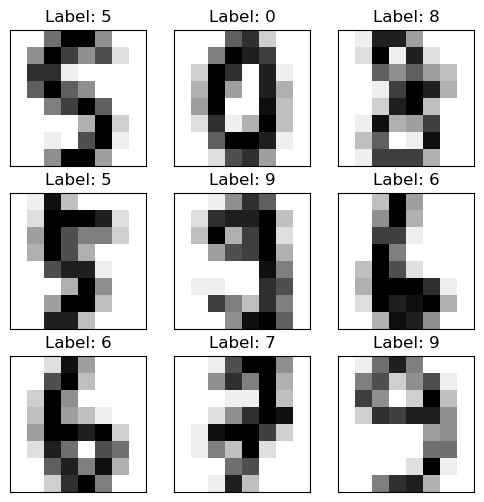

In [22]:
# Selecting 9 random indices
random_indices = np.random.choice(len(digits.images), 9, replace=False)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[random_indices[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Label: {digits.target[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

As you can see, these images are very low resolution. This is because they were originally scanned from paper forms, and then scaled down to 8x8 pixels. This is a common problem in machine learning - the quality of the data is often a limiting factor in the performance of the model. In this case, the low resolution of the images makes it difficult to distinguish between some digits, even for humans. For example, the following images are all labelled as 9, but they look very different:

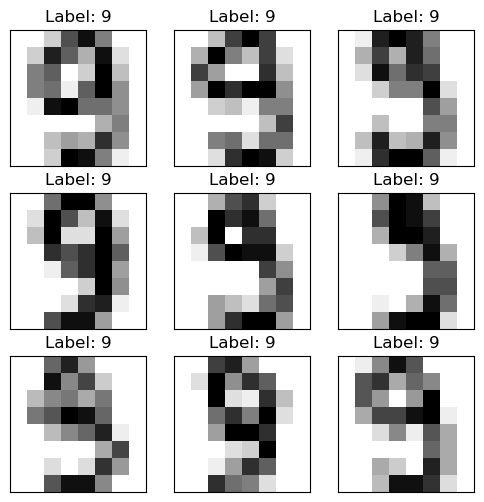

In [23]:
# Selecting 9 random indices of images labelled as 9
random_indices = np.random.choice(np.where(digits.target == 9)[0], 9, replace=False)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[random_indices[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Label: {digits.target[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

While we are plotting the samples as images, remember that our model is only going to see a 1D array of numbers. 

## Train / Test Split

In order to understand how well our model performs on _new_ data, we need to split our dataset into a training set and a test set. The training set will be used to train the model, and the test set will be used to evaluate the performance of the model.

Let's keep some held-out data to be able to measure the generalization performance of our model. 

In [24]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    digits.data, 
    digits.target,
    test_size=0.2, # 20% of the data is used for testing
    random_state=42 # Providing a value here means getting the same "random" split every time
)

Let's confirm that the data has been split correctly:

In [25]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1437, 64)
y_train shape: (1437,)
X_test shape: (360, 64)
y_test shape: (360,)


This is what we expected to see. It's always good to check as you go, to make sure that you haven't made a mistake somewhere - this is something that working in a notebook like this makes it easy to do.

## Preprocessing of the Target Data

The labels that we have are integers between 0 and 9. However, we want to train a neural network to classify the images into one of 10 classes. It can be a little counter-intuitive because we are dealing with numbers, but our classes are not ordinal.

What do we mean by that? Let's imagine we were trying to predict the height of a building (separated into classes) from images. If a given building was actually 10m tall, and our model predicted 9m, we would consider that to be a better prediction than if it predicted 1m. This is because the classes are ordinal - there is meaning in the difference between the classes.

In our case, even though we are dealing with numbers, the classes are not ordinal. If a given image is actually a 9, and our model predicts 8, we would consider that to be just as bad as if it predicted 1. This is because the classes are not ordered, and the difference between the classes is not meaningful.

Because of this, we need to convert our labels from an integer value into a one-hot encoded vector. This means that each label will be represented as a vector of length 10, with a 1 in the position corresponding to the class, and 0s everywhere else. For example, the label 9 would be represented as `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`. This is a common way of representing categorical data in machine learning. By doing this, we ensure that our model is taught the correct relationship between the classes.

In [26]:
from tensorflow.keras.utils import to_categorical

print(f'Before one-hot encoding: {y_train[0]}')

# convert the venctor in a one-hot encoded vector (i.e. 9 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] )
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(f'After one-hot encoding: {y_train[0]}')

Before one-hot encoding: 6
After one-hot encoding: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Feed Forward Neural Networks with Keras

Now that we have prepared our data, it's time to build a simple neural network! In this section, we will use the Keras API to build a simple feed forward neural network. We will then train the model on the MNIST dataset, and evaluate its performance on the test set.

In most modern deep learning frameworks, the process of building a model can be broken down into a few steps:

- Define the model architecture: this is where we define the layers of the model, and how they are connected to each other.
- Compile the model: this is where we define the loss function, the optimizer, and the metrics that we want to use to evaluate the model.
- Train the model: this is where we train the model on the training data.

Let's start with defining the model architecture. There are two ways to do this in Keras - the Sequential API and the Functional API. The Sequential API is the simplest way to build a model, and is suitable for most use cases. The Functional API is more flexible, and allows you to build more complex models. We will start with the Sequential API, and then we will look at the Functional API later in the course.

Our simple neural network will be "fully-connected". This means that each neuron in a given layer is connected to every neuron in the next layer. This is also known as a "dense" layer. We will use the `Dense` class from Keras to define our layers.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

# Input layer
model.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64
## activation='relu' -> the non-linear element of the layer
## input_shape=(64,)  -> 8 x 8 pixes = 64

# Hidden layer
model.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation

# Output layer
model.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 8,970
Trainable params: 8,970
Non-trainable params: 0
_________________________________________________________________


Congratulations! You have just built your first neural network with Keras. As we can confirm from the `model.summary()` output, our model has 3 layers. The first layer has 64 neurons, the second layer has 64 neurons, and the output layer has 10 neurons. The output layer uses the softmax activation function, which is commonly used for multi-class classification problems. The other layers use the ReLU activation function, which is commonly used for hidden layers in neural networks.

Next, we need to compile the model. This is where we define the loss function, the optimizer, and the metrics that we want to use to evaluate the model. We will use the `compile` method of the model to do this.

In [28]:
model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer='sgd', # Optimizer
    # optimizer=optimizers.SGD(learning_rate=0.01),  # Optimizer
    metrics=['accuracy'] # Metrics to evaluate the model
)

Because we are predicting which class a sample belongs to, we will use the `categorical_crossentropy` function. This loss function is commonly used for multi-class classification problems. 

For our optimizer, we are using the standard stochastic gradient descent (SGD) algorithm. This is a simple optimizer that works well for many problems. We will look at more advanced optimizers later in the course.

Finally, we are using the `accuracy` metric to evaluate the model. This is a common metric for classification problems, and it is simply the fraction of samples that are correctly classified. This is an easier metric for us to understand, but it's not quite as useful for actually training the model (for example, it doesn't tell us how "confident" the model is in its predictions).

Now that we have (a) defined the model architecture and (b) compiled the model, we are ready to train the model. We will use the `fit` method of the model to do this.

In [29]:
history = model.fit(
    X_train, # Training data
    y_train, # Training labels
    epochs=15, # Number of epochs
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

# the "loss" below shows how far the correct result is ... as more iterations (epochs) the loss reduces

Epoch 1/15
36/36 [==============================] - 1s 13ms/step - loss: 1.7995 - accuracy: 0.5100 - val_loss: 0.7232 - val_accuracy: 0.7743
Epoch 2/15
36/36 [==============================] - 0s 4ms/step - loss: 0.5605 - accuracy: 0.8407 - val_loss: 0.4429 - val_accuracy: 0.8611
Epoch 3/15
36/36 [==============================] - 0s 4ms/step - loss: 0.3720 - accuracy: 0.8964 - val_loss: 0.3928 - val_accuracy: 0.8854
Epoch 4/15
36/36 [==============================] - 0s 4ms/step - loss: 0.2913 - accuracy: 0.9130 - val_loss: 0.2543 - val_accuracy: 0.9271
Epoch 5/15
36/36 [==============================] - 0s 4ms/step - loss: 0.2183 - accuracy: 0.9426 - val_loss: 0.2300 - val_accuracy: 0.9444
Epoch 6/15
36/36 [==============================] - 0s 5ms/step - loss: 0.1977 - accuracy: 0.9460 - val_loss: 0.2168 - val_accuracy: 0.9340
Epoch 7/15
36/36 [==============================] - 0s 5ms/step - loss: 0.1597 - accuracy: 0.9600 - val_loss: 0.1882 - val_accuracy: 0.9479
Epoch 8/15
36/36 [=

We have now trained our model! We can see that the model has been trained for 5 epochs, and the loss and accuracy have been printed for each epoch. We can also see that the model has been evaluated on the validation data at the end of each epoch. This is useful for us to see how the model is performing on data that it hasn't seen during training.

Once the model is trained, it's time to evaluate the model on the test set. We can use the `evaluate` method of the model to do this. If you were building a model for a real-world application, this is the very last thing you would do, and the result here would be the figure you'd report in your paper or presentation.

In [30]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss:     {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

12/12 [==============================] - 0s 3ms/step - loss: 0.1553 - accuracy: 0.9472
Loss:     0.16
Accuracy: 94.72%


Hopefully you have achieved an accuracy of around 95%. This is pretty good, but we can do better! In the next section, we will look at how we can improve the performance of our model by using a more advanced optimizer. But before we get there, let's do one other thing - let's look at the predictions that our model is making on the test set. When you are building a model, it's often useful to have a look at some of the examples your model is getting wrong. Sometimes this can reveal problems with the data, or it can give you ideas for how to improve your model.

12/12 [==============================] - 0s 3ms/step


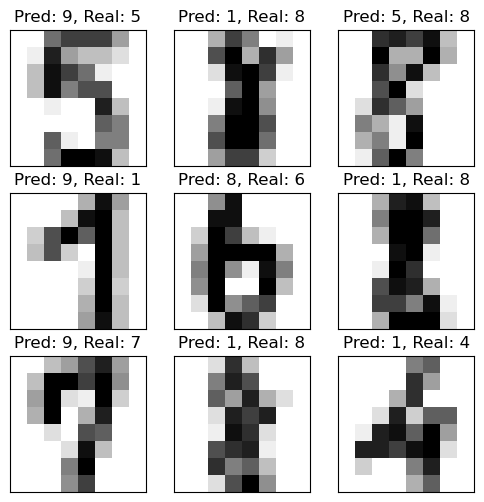

In [31]:
# Get the predictions for the test data
predictions = model.predict(X_test)

# Get the index of the largest probability (i.e. the predicted class)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Get the misclassified samples themselves
misclassified_samples = X_test[misclassified_indices]
misclassified_labels = np.argmax(y_test[misclassified_indices], axis=1)

# Pick 9 random misclassified samples
random_indices = np.random.choice(len(misclassified_indices), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(misclassified_samples[random_indices[i]].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"Pred: {predicted_classes[misclassified_indices[random_indices[i]]]}, Real: {misclassified_labels[random_indices[i]]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

What do you think? Would you have made the same mistakes as the model? Determining whether the mistakes are "understandable" is a rough way of seeing if you could improve the model further, or if this is the best you can do with the data you have.

### b) Exercises: Impact of the Optimizer

In this section, you will play around with the optimizer and see how it affects the performance of the model. We will start with the standard SGD optimizer, and then we will look at more advanced optimizers.

1. Try decreasing the learning rate of the SGD optimizer by a factor of 10, or 100. What do you observe?
2. Try increasing the learning rate of the SGD optimizer. What happens?
3. The SGD optimizer has a momentum parameter. In a nutshell, this parameter controls how much the gradient from the previous step affects the current step. Try enabling momentum in the SGD optimizer with a value of 0.9. What happens?
  
**Notes**: 

The keras API documentation is available at:

https://www.tensorflow.org/api_docs/python/tf/keras

It is also possible to learn more about the parameters of a class by using the question mark: type and evaluate:

```python
optimizers.SGD?
```

in a jupyter notebook cell.

It is also possible to type the beginning of a function call / constructor and type "shift-tab" after the opening paren:

```python
optimizers.SGD(<shift-tab>
```

In [32]:
# Your code here - copy the relevant parts from the previous section and add more cells as needed

model2 = Sequential()

# Input layer
model2.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64
## activation='relu' -> the non-linear element of the layer
## input_shape=(64,)  -> 8 x 8 pixes = 64

# Hidden layer
model2.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation

# Output layer
model2.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model2.summary()

model2.compile(
    loss='categorical_crossentropy', # Loss function
    # optimizer='sgd', # Optimizer 
    optimizer = optimizers.SGD(learning_rate = 0.001),  # Optimizer
                                                        ## Start the rate with 0.1 ... then 0.01 ... 0.001
                                                        ## SGD = Stochastic Gradient Descent
                                                        ## momentum = learn from past iterations
    metrics=['accuracy'] # Metrics to evaluate the model
)

history2 = model2.fit (X_train , y_train, epochs = 15, batch_size=32)

# when learning_rate = 0.01 the loss start at 1.1436 and finish at 0.0395
# when learning_rate = 0.001 the loss start at 4.2435 and finish at 0.3474

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 8,970
Trainable params: 8,970
Non-trainable params: 0
_________________________________________________________________


NameError: name 'optimizers' is not defined

Next, let's try a more advanced optimizer. Adam is likely the most popular optimizer for deep learning. It is an adaptive learning rate optimizer, which means that it automatically adjusts the learning rate based on how the training is going. This can be very useful, as it means that we don't need to manually tune the learning rate. Let's see how it performs on our model.


1. Replace the SGD optimizer by the Adam optimizer from keras and run it
  with the default parameters.

2. Add another hidden layer with ReLU activation and 64 neurons. Does it improve the model performance?


In [ ]:
# Your code here
model3 = Sequential()

# Input layer
model3.add(Dense(64, activation='relu', input_shape=(64,))) # 64 neurons, ReLU activation, input shape of 64
## activation='relu' -> the non-linear element of the layer
## input_shape=(64,)  -> 8 x 8 pixes = 64

# Hidden layer
model3.add(Dense(64, activation='relu')) # 64 neurons, ReLU activation

# Output layer
model3.add(Dense(10, activation='softmax')) # 10 neurons, softmax activation

model3.summary()

model3.compile(
    loss='categorical_crossentropy', # Loss function
    #optimizer='sgd', # Optimizer
    optimizer = optimizers.SGD(learning_rate = 0.01, momentum = 0.9),  # Optimizer
    metrics=['accuracy'] # Metrics to evaluate the model
)

history3 = model3.fit (X_train , y_train, epochs = 15, batch_size=32)

# add momentum = 0.9 made the model converge much faster!


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 64)                4160      
                                                                 
 dense_58 (Dense)            (None, 64)                4160      
                                                                 
 dense_59 (Dense)            (None, 64)                4160      
                                                                 
 dense_60 (Dense)            (None, 10)                650       
                                                                 
Total params: 13,130
Trainable params: 13,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
45/45 [==============================] - 1s 3ms/step - loss: 1.2731 - accuracy: 0.6200
Epoch 2/15
45/45 [==============================] - 0s 3ms/step - loss: 0.2995 - ac

### Exercises: Forward Pass and Generalization

Let's look in more detail at how the model makes predictions on the test set. We will walk through each step of making predictions, examining exactly what's going on.

To start, we will apply our model to the test set, and look at what we get as output:

In [ ]:
predictions_tf = model(X_test)
predictions_tf[:5]

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[2.01610947e-05, 7.55960218e-06, 2.45392670e-07, 1.76713542e-08,
        7.70610422e-05, 3.58318943e-07, 9.99848604e-01, 2.34051910e-07,
        4.30468936e-05, 2.67843689e-06],
       [6.79845971e-06, 4.30888258e-06, 4.65209723e-07, 1.81360316e-04,
        2.68620315e-05, 1.10774614e-01, 9.23767686e-07, 3.25655164e-05,
        2.54029110e-05, 8.88946652e-01],
       [2.65371341e-07, 1.74665843e-06, 1.35219059e-04, 9.99066591e-01,
        8.92157725e-09, 2.44493101e-04, 1.83341399e-06, 1.30510580e-05,
        3.60010163e-05, 5.00697701e-04],
       [3.41087510e-03, 1.53925980e-03, 8.68740099e-05, 4.81530267e-04,
        4.84982133e-03, 5.71268005e-03, 3.24576795e-05, 9.69265282e-01,
        2.75058788e-04, 1.43461870e-02],
       [6.00838257e-06, 2.08698821e-05, 9.86978292e-01, 7.96403550e-03,
        2.35178432e-09, 1.64047997e-05, 2.10691214e-05, 6.17229762e-06,
        4.95013734e-03, 3.69187910e-05]], dtype=float32)>

In [ ]:
type(predictions_tf), predictions_tf.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([360, 10]))

The raw output of the model is a tensor of shape `(360, 10)`. This means that we have 360 samples, and for each sample we have 10 values. Each of these values represents the probability that the sample belongs to a given class. This means that we have 10 probabilities for each sample, and the sum of these probabilities is 1. We can confirm this by summing the probabilities for each sample:

In [ ]:
import tensorflow as tf

tf.reduce_sum(predictions_tf, axis=1)[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.99999994, 0.99999994, 0.9999999 , 1.        , 0.9999999 ],
      dtype=float32)>

...okay, there might be a small rounding error here and there. This is to do with how floating point numbers are represented in computers, and it's not something we need to worry about for now.

We can also extract the label with the highest probability using the tensorflow API:

In [ ]:
predicted_labels_tf = tf.argmax(predictions_tf, axis=1)
predicted_labels_tf[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([6, 9, 3, 7, 2], dtype=int64)>

One helpful aspect of this approach is that we don't just get the prediction, but also a sense of how confident the model is in its prediction. To see this in practice, let's take a look at some of the predictions the model is highly confident about (i.e. a lot of the probability mass is on one class):

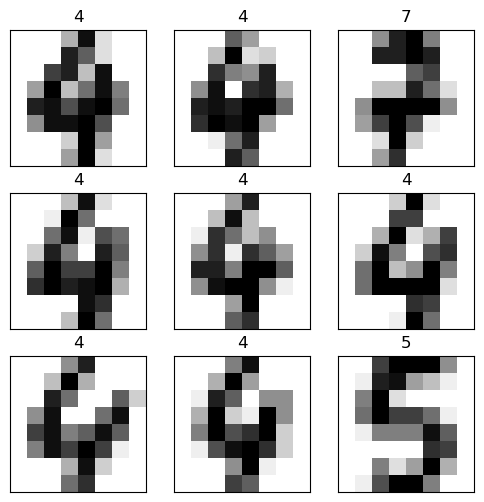

In [ ]:
# Get the values corresponding to the predicted labels for each sample
predicted_values_tf = tf.reduce_max(predictions_tf, axis=1)

# Get the indices of the samples with the highest predicted values
most_confident_indices_tf = tf.argsort(predicted_values_tf, direction='DESCENDING').numpy()[:9]

# Get the 9 most confident samples
most_confident_samples_tf = X_test[most_confident_indices_tf]

# Get the true labels for the 9 most confident samples
most_confident_labels_tf = np.argmax(y_test[most_confident_indices_tf], axis=1)

# Plot the 9 most confident samples
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(most_confident_samples_tf[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f"{most_confident_labels_tf[i]}")

    # Removing axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

## Impact of Initialization

Let's study the impact of a bad initialization when training
a deep feed forward network.

By default, Keras dense layers use the "Glorot Uniform" initialization
strategy to initialize the weight matrices:

- each weight coefficient is randomly sampled from [-scale, scale]
- scale is proportional to $\frac{1}{\sqrt{n_{in} + n_{out}}}$

This strategy is known to work well to initialize deep neural networks
with "tanh" or "relu" activation functions and then trained with
standard SGD.

To assess the impact of initialization let us plug an alternative init
scheme into a 2 hidden layers networks with "tanh" activations.
For the sake of the example let's use normal distributed weights
with a manually adjustable scale (standard deviation) and see the
impact the scale value:

In [ ]:
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

input_dim = 64
hidden_dim = 64
output_dim = 10

normal_init = initializers.TruncatedNormal(stddev=0.01, seed=42)

model = Sequential()

model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh",
                kernel_initializer=normal_init))

model.add(Dense(hidden_dim, activation="tanh",
                kernel_initializer=normal_init))

model.add(Dense(output_dim, activation="softmax",
                kernel_initializer=normal_init))

model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.layers

Let's have a look at the parameters of the first layer after initialization but before any training has happened:

In [ ]:
model.layers[0].weights

[<tf.Variable 'dense_54/kernel:0' shape=(64, 64) dtype=float32, numpy=
 array([[ 1.58170762e-04, -1.59008689e-02,  1.03594456e-03, ...,
          9.62818228e-03,  6.24957308e-03,  9.94726177e-03],
        [ 1.39539372e-02, -5.69676049e-03, -5.13145979e-03, ...,
         -1.02958630e-03, -1.21196425e-02, -2.44869553e-02],
        [ 5.01998402e-02, -9.82458517e-02, -7.56048784e-02, ...,
         -2.58549545e-02, -1.31364897e-01,  6.37659729e-02],
        ...,
        [ 1.18982757e-03, -6.24336228e-02,  1.17749006e-01, ...,
         -8.82261172e-02,  1.02415688e-01, -1.81099668e-01],
        [ 2.07840689e-02, -7.84315094e-02,  9.63484794e-02, ...,
         -7.32458383e-02,  1.85409784e-02, -8.82382244e-02],
        [ 3.17696668e-02,  2.53611070e-04,  4.91540954e-02, ...,
          5.60919531e-02,  2.28674076e-02, -4.73014042e-02]], dtype=float32)>,
 <tf.Variable 'dense_54/bias:0' shape=(64,) dtype=float32, numpy=
 array([-6.6187372e-04, -2.3550717e-03,  1.3371912e-03, -3.8229041e-03,
    

In [33]:
w = model.layers[0].weights[0].numpy()
w

array([[ 0.06731682, -0.07228914, -0.02729997, ..., -0.03373626,
        -0.16472492,  0.14708449],
       [ 0.03936407, -0.04190024, -0.21175031, ...,  0.09714254,
        -0.1357641 , -0.02659014],
       [-0.01293294, -0.12300672, -0.10697932, ...,  0.17008992,
         0.13367833,  0.17814828],
       ...,
       [-0.10038964,  0.22071138, -0.09635323, ...,  0.12023941,
         0.05057957, -0.22548944],
       [-0.04558145,  0.10646859,  0.06065428, ...,  0.19841313,
        -0.09907063,  0.10483395],
       [-0.16772194,  0.05888703,  0.10425311, ..., -0.04792209,
        -0.00142632, -0.11683841]], dtype=float32)

In [34]:
w.std()

0.1267072

In [35]:
b = model.layers[0].weights[1].numpy() # show the bias
b

array([-3.8769931e-04,  2.1897827e-03, -2.1124193e-03, -1.0370911e-03,
        0.0000000e+00, -4.1209762e-03,  1.2922066e-03,  1.6307754e-03,
        3.2481288e-03,  8.3729549e-04,  3.0569325e-03,  6.7648478e-04,
       -2.8090046e-03, -1.5770485e-04, -3.7074642e-06, -7.2759454e-04,
       -5.5730855e-04,  1.7474560e-03, -1.9707666e-03, -9.7716087e-04,
        2.0404323e-03, -3.7269565e-04, -1.5398330e-03,  2.0607446e-04,
       -1.2320139e-03,  4.7659839e-04,  1.4347569e-03,  2.4393002e-04,
       -3.1323667e-04,  9.7013166e-04, -1.9801734e-03, -1.3556602e-04,
        8.7341381e-04,  9.3386850e-05, -1.4580523e-03, -7.4650242e-04,
        7.4114039e-04,  3.0690129e-03,  2.2615127e-03, -9.7647612e-04,
        1.4067041e-03,  1.5799669e-03, -7.0647988e-04, -4.8915867e-05,
       -9.8053750e-04,  1.7963435e-03, -5.0048617e-04, -1.6057796e-03,
       -1.2342197e-04, -8.1842433e-04,  2.6119384e-05, -1.4240472e-03,
        0.0000000e+00,  9.2232123e-04,  2.1660035e-06, -2.2430660e-04,
      

Epoch 1/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0819 - accuracy: 0.9833
Epoch 2/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.9889
Epoch 3/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9889
Epoch 4/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9861
Epoch 5/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0538 - accuracy: 0.9903
Epoch 6/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 0.9937
Epoch 7/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.9903
Epoch 8/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0427 - accuracy: 0.9903
Epoch 9/15
45/45 [==============================] - 0s 3ms/step - loss: 0.0380 - accuracy: 0.9930
Epoch 10/15
45/45 [==============================] - 0s 4ms/step - loss: 0.0375 - accuracy: 0.9923
Epoch 11/15
45/45 [

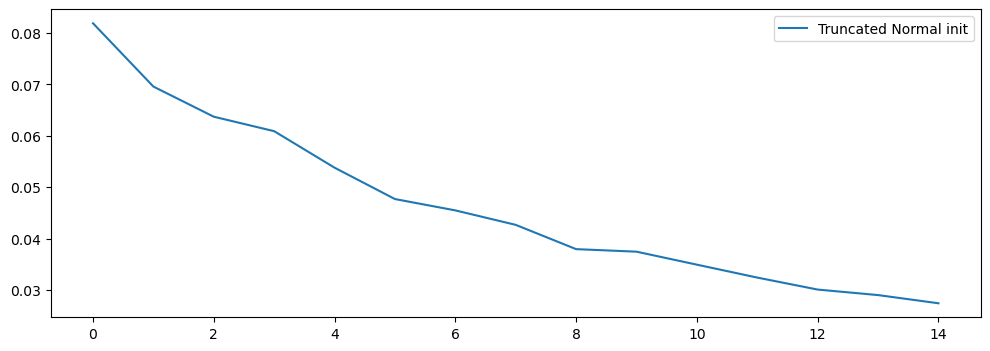

In [36]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label="Truncated Normal init")
plt.legend()

Once the model has been fit, the weights have been updated and notably the biases are no longer 0:

In [ ]:
model.layers[0].weights

[<tf.Variable 'dense_54/kernel:0' shape=(64, 64) dtype=float32, numpy=
 array([[ 1.58170762e-04, -1.59008689e-02,  1.03594456e-03, ...,
          9.62818228e-03,  6.24957308e-03,  9.94726177e-03],
        [ 1.39539372e-02, -5.69676049e-03, -5.13145979e-03, ...,
         -1.02958630e-03, -1.21196425e-02, -2.44869553e-02],
        [ 5.01998402e-02, -9.82458517e-02, -7.56048784e-02, ...,
         -2.58549545e-02, -1.31364897e-01,  6.37659729e-02],
        ...,
        [ 1.18982757e-03, -6.24336228e-02,  1.17749006e-01, ...,
         -8.82261172e-02,  1.02415688e-01, -1.81099668e-01],
        [ 2.07840689e-02, -7.84315094e-02,  9.63484794e-02, ...,
         -7.32458383e-02,  1.85409784e-02, -8.82382244e-02],
        [ 3.17696668e-02,  2.53611070e-04,  4.91540954e-02, ...,
          5.60919531e-02,  2.28674076e-02, -4.73014042e-02]], dtype=float32)>,
 <tf.Variable 'dense_54/bias:0' shape=(64,) dtype=float32, numpy=
 array([-6.6187372e-04, -2.3550717e-03,  1.3371912e-03, -3.8229041e-03,
    

#### Questions:

- Try the following initialization schemes and see whether
  the SGD algorithm can successfully train the network or
  not:
  
  - a very small e.g. `stddev=1e-3`
  - a larger scale e.g. `stddev=1` or `10`
  - initialize all weights to 0 (constant initialization)
  
- What do you observe? Can you find an explanation for those
  outcomes?

- Are more advanced solvers such as SGD with momentum or Adam able
  to deal better with such bad initializations?

Training model with stddev =  0.001
Epoch 1/15
45/45 [==============================] - 1s 2ms/step - loss: 2.3037 - accuracy: 0.1002
Epoch 2/15
45/45 [==============================] - 0s 3ms/step - loss: 2.3034 - accuracy: 0.0953
Epoch 3/15
45/45 [==============================] - 0s 2ms/step - loss: 2.3032 - accuracy: 0.1072
Epoch 4/15
45/45 [==============================] - 0s 2ms/step - loss: 2.3032 - accuracy: 0.1072
Epoch 5/15
45/45 [==============================] - 0s 2ms/step - loss: 2.3033 - accuracy: 0.1072
Epoch 6/15
45/45 [==============================] - 0s 2ms/step - loss: 2.3031 - accuracy: 0.1072
Epoch 7/15
45/45 [==============================] - 0s 3ms/step - loss: 2.3032 - accuracy: 0.1072
Epoch 8/15
45/45 [==============================] - 0s 2ms/step - loss: 2.3027 - accuracy: 0.1072
Epoch 9/15
45/45 [==============================] - 0s 2ms/step - loss: 2.3017 - accuracy: 0.1002
Epoch 10/15
45/45 [==============================] - 0s 2ms/step - loss: 2.1301 - 

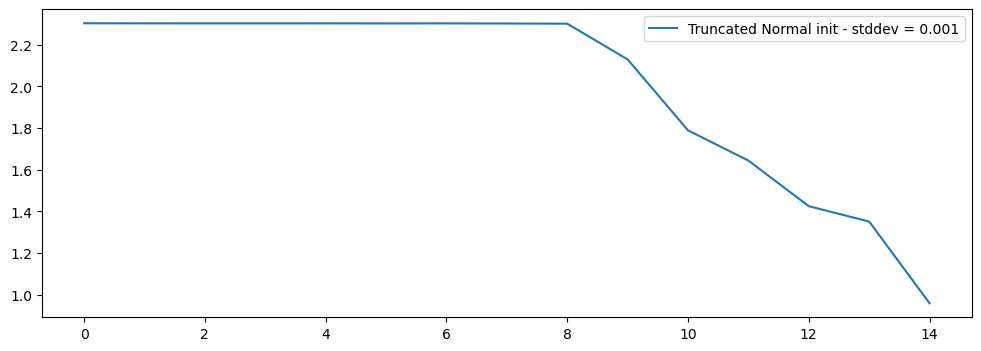

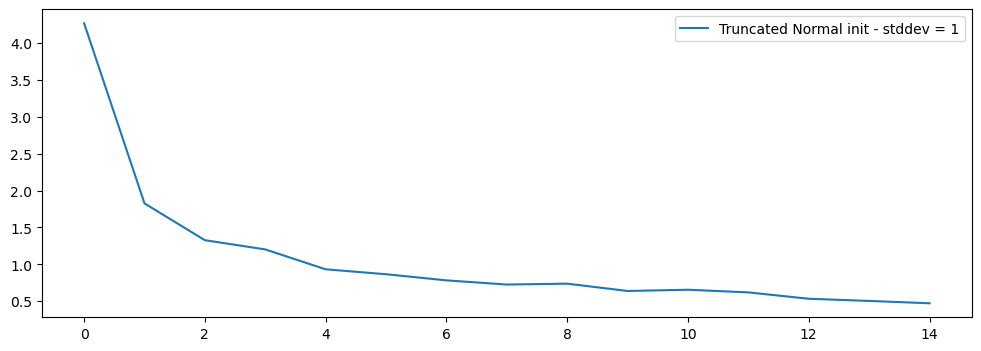

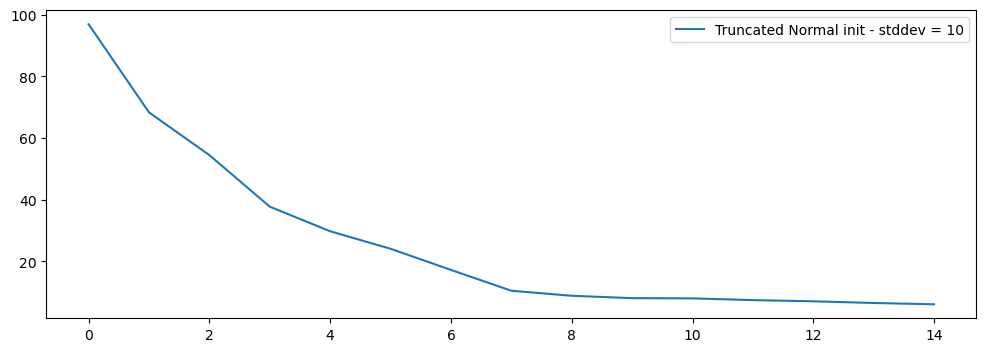

In [57]:
# Your code here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

input_dim = 64
hidden_dim = 64
output_dim = 10
history = {}

#############################
# Define the model
#############################

stddev_options = [1e-3, 1 , 10]
i=0
for stddev in stddev_options:

    print ("Training model with stddev = ",stddev)
    normal_init = initializers.TruncatedNormal(stddev = stddev, seed=42)

    model = Sequential()

    model.add(Dense(hidden_dim, 
                input_dim=input_dim, 
                activation="tanh", 
                kernel_initializer=normal_init))

    model.add(Dense(hidden_dim, 
                activation="tanh",
                kernel_initializer=normal_init))

    model.add(Dense(output_dim, 
                activation="softmax",
                kernel_initializer=normal_init))

    ##############################
    # compile de model
    ##############################

    model.compile(optimizer=optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    ##############################
    # train de model
    ##############################
    history = model.fit(X_train, y_train, epochs=15, batch_size=32)

    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label="Truncated Normal init - stddev = " + str(stddev))
    plt.legend()
